In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as T
from collections import defaultdict, deque
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
#from torchvision.models.detection.rpn import AnchorGenerator
import ast
!pip install albumentations==0.4.6
from torch.utils.data import DataLoader, Dataset
#from torch.utils.data.sampler import SequentialSampler
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import seaborn as sns
import os,sys,matplotlib,re
#from PIL import Image
#from skimage import exposure
import matplotlib.pyplot as plt
#from google.colab import drive
import matplotlib.image as immg

  Using cached albumentations-0.4.6.tar.gz (117 kB)
  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65161 sha256=6d4a5dc2edbb6ffbf1aa3c20a6bd84d74b134c9bc85458a9560e0ad2f7b54760
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\d2\e3\0b\99a239413035502833a7b07283894243fddf5ce3aa720ca8dd
Successfully built albumentations


In [3]:

path = 'C:/Users/Admin/Pictures/14659/14659_Final code/train/'
#read the train dataset
#from google.colab import drive
#drive.mount('/content/dataset_wheat/')
train_df = pd.read_csv('C:/Users/Admin/Pictures/14659/14659_Final code/train.csv')
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [4]:
train_df['x_min'] = -1
train_df['y_min'] = -1
train_df['w'] = -1
train_df['h'] = -1

train_df[['x_min', 'y_min', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: ast.literal_eval(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x_min'] = train_df['x_min'].astype(np.float)
train_df['y_min'] = train_df['y_min'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)
train_df['x_max'] = train_df['x_min']+train_df['w']
train_df['y_max'] = train_df['y_min']+train_df['h']
train_df.head()

<ipython-input-4-5a567eeed6ae>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_df['x_min'] = train_df['x_min'].astype(np.float)
<ipython-input-4-5a567eeed6ae>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_df['y_min'] = train_df['y_min'].astype(np.float)
<ipython-input-4-5a567eeed6ae>:10: DeprecationWarning: `np.float` is a

,image_id,width,height,source,x_min,y_min,w,h,x_max,y_max
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0,890.0,258.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0,356.0,606.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0,451.0,664.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0,943.0,202.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0,150.0,261.0


In [5]:
df = train_df.copy()
'''
df['x_min'] = df['x_min']*512/1024
df['x_max'] = np.ceil(df['x_max']*512/1024)
df['y_min'] = df['y_min']*512/1024
df['y_max'] = np.ceil(df['y_max']*512/1024)'''
df.describe()

,width,height,x_min,y_min,w,h,x_max,y_max
count,147793.0,147793.0,147793.000000,147793.000000,147793.00000,147793.000000,147793.000000,147793.000000
mean,1024.0,1024.0,472.381631,475.386907,84.43506,76.927306,556.816691,552.314212
std,0.0,0.0,303.555566,300.815509,35.55345,33.853186,302.305344,298.944521
min,1024.0,1024.0,0.000000,0.000000,1.00000,1.000000,2.000000,2.000000
25%,1024.0,1024.0,203.000000,213.000000,62.00000,55.000000,292.000000,294.000000
50%,1024.0,1024.0,475.000000,477.000000,78.00000,71.000000,563.000000,556.000000
75%,1024.0,1024.0,737.000000,737.000000,100.00000,91.000000,823.000000,814.000000
max,1024.0,1024.0,1023.000000,1023.000000,987.00000,714.000000,1024.000000,1024.000000


# Hough Trasnform
Pre-Processing

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Read image.
img = cv2.imread('C:/Users/Admin/Pictures/14659/test/2fd875eaa.jpg', cv2.IMREAD_COLOR)
  
# Convert to grayscale.
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
# Blur using 3 * 3 kernel.
gray_blurred = cv2.blur(gray, (3, 3))
  
# Apply Hough transform on the blurred image.
detected_circles = cv2.HoughCircles(gray_blurred, 
                   cv2.HOUGH_GRADIENT, 1, 20, param1 = 50,
               param2 = 30, minRadius = 1, maxRadius = 40)
#fig,ax = plt.subplots(figsize=(18,10))
#ax.imshow(img,cmap='binary')
  
# Draw circles that are detected.
if detected_circles is not None:
  
    # Convert the circle parameters a, b and r to integers.
    detected_circles = np.uint16(np.around(detected_circles))
  
    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
  
        # Draw the circumference of the circle.
        cv2.circle(img, (a, b), r, (0, 255, 0), 2)
  
        # Draw a small circle (of radius 1) to show the center.
        cv2.circle(img, (a, b), 1, (0, 0, 255), 3)
        fig,ax = plt.subplots(figsize=(18,10))
        ax.imshow(img,cmap='binary')
plt.show("Detected Circle", img)
#cv2.waitKey(0)

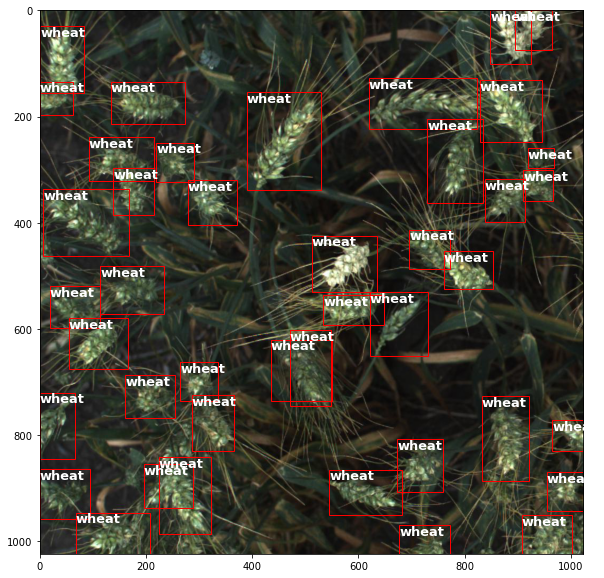

In [6]:
df = df.reset_index(drop=True)
df_grp = df.groupby(['image_id'])
b_fea = ['x_min', 'y_min', 'x_max', 'y_max']
import matplotlib
name = df.image_id.unique()[9]
loc = path+name+'.jpg'
aaa = df_grp.get_group(name)
bbx = aaa.loc[:,b_fea]
img = immg.imread(loc)
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img,cmap='binary')

for i in range(len(bbx)):
    box = bbx.iloc[i].values
    x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
    ax.text(*box[:2], "wheat", verticalalignment='top', color='white', fontsize=13, weight='bold')
    ax.add_patch(rect)
plt.show()

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
class WheatDataset(object):
    def __init__(self, df, IMG_DIR, transforms=None):
        # select only those classes that have boxes
        
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['image_id'].unique().tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
    
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]
        #image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        #print('ananth',f'{self.img_dir}/{image_id}.jpg')
        image = cv2.imread(f'{self.img_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)  #reading an image
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)    #changing color space BGR --> RGB
        image /= 255.0
        
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros((records.shape[0],), dtype=torch.int64)
    
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target['boxes'] =  torch.tensor(sample['bboxes']).float()
        return torch.tensor(image), target, image_id

In [8]:
IMG_SIZE = (512,512)
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
img_dir = 'C:/Users/Admin/Pictures/14659/14659_Final code/train/'
WDS = WheatDataset(df, img_dir ,get_train_transform())

<ipython-input-7-58334e9f06be>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), target, image_id


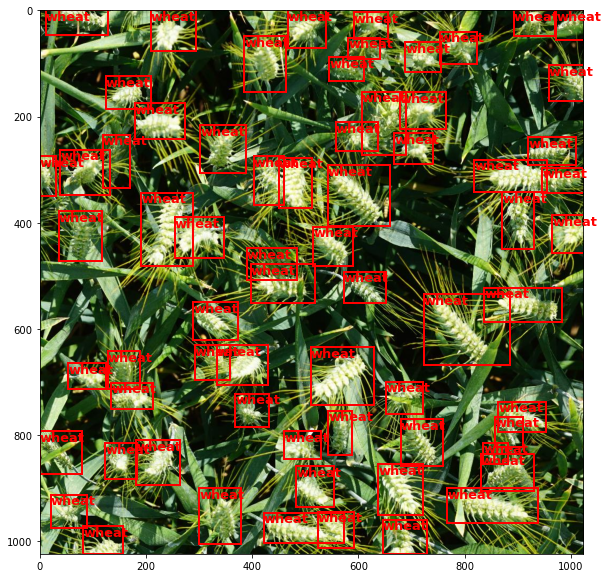

In [9]:
import random
img, tar,_ = WDS[random.randint(0,1000)]
bbox = tar['boxes'].numpy()
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())

for i in range(len(bbox)):
    box = bbox[i]
    x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
    ax.text(*box[:2], "wheat", verticalalignment='top', color='red', fontsize=13, weight='bold')
    ax.add_patch(rect)
plt.show()

In [ ]:
# save the CSV 
train_df.to_csv('C:/Users/Admin/Pictures/14659/14659_Final code/train.csv', index=False)

In [ ]:
grouped = train_df.groupby(['image_id'])
print(len(grouped))
grouped.head()

In [ ]:
count = 0
for key, item in grouped:
    print(key)
    print(type(item))
    print(item)
    print(len(item))
    print('\n')
    count += 1
    if count == 2:
        break

print(count)

In [ ]:
DIR_TRAIN = 'C:/Users/Admin/Pictures/14659/14659_Final code/train/'

In [ ]:
count = 0
# number of images to show
viz_thres = 25
for key, item in grouped:
    print(key)
    print('\n')
    image = cv2.imread(f"{DIR_TRAIN}/{key}.jpg")
    cv2.putText(image, f"{len(item)} wheat heads", (10, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 255, 0), 5)
    for i in range(len(item)):
        x1 = int(item.iloc[i]['x_min'])
        y1 = int(item.iloc[i]['y_min'])
        x2 = int(x1 + item.iloc[i]['w'])
        y2 = int(y1 + item.iloc[i]['h'])
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)
    plt.figure(figsize=(15, 12))
    plt.imshow(image[:, :, ::-1])
    plt.axis('off')
    plt.show()
    count += 1
    if count == viz_thres:
        break

In [12]:

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
dataset=img
def white_balance_loops(img):
    result = cv.cvtColor(img, cv.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    for x in range(result.shape[0]):
        for y in range(result.shape[1]):
            l, a, b = result[x, y, :]
            # fix for CV correction
            l *= 100 / 255.0
            result[x, y, 1] = a - ((avg_a - 128) * (l / 100.0) * 1.1)
            result[x, y, 2] = b - ((avg_b - 128) * (l / 100.0) * 1.1)
    result = cv.cvtColor(result, cv.COLOR_LAB2BGR)
    return result
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    white=white_balance_loops(input_image)
    import cv2
    import numpy as np
    img = cv2.medianBlur(img,5)
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                              param1=50,param2=30,minRadius=0,maxRadius=0)

    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
      # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
      # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
    # both use the same seed, so they'll make the same randomn changes.
        self.augment_inputs = preprocessing.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = preprocessing.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
    
        TRAIN_LENGTH = info.splits['train'].num_examples
        BATCH_SIZE = 64
        BUFFER_SIZE = 1000
        STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
        train_images = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
        test_images = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels
        train_batches = (train_images.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE))
    
'''
def display(display_list):
  test_batches = test_images.batch(BATCH_SIZE)
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
  for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])
'''


"\ndef display(display_list):\n  test_batches = test_images.batch(BATCH_SIZE)\n  plt.figure(figsize=(15, 15))\n\n  title = ['Input Image', 'True Mask', 'Predicted Mask']\n\n  for i in range(len(display_list)):\n    plt.subplot(1, len(display_list), i+1)\n    plt.title(title[i])\n    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))\n    plt.axis('off')\n  plt.show()\n  for images, masks in train_batches.take(2):\n    sample_image, sample_mask = images[0], masks[0]\n    display([sample_image, sample_mask])\n"

In [13]:
image_ids = df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = df[df['image_id'].isin(valid_ids)]
train_df = df[df['image_id'].isin(train_ids)]
train_df.shape,valid_df.shape
def collate_fn(batch):
    return tuple(zip(*batch))
train_dataset = WheatDataset(train_df,img_dir , get_train_transform())
valid_dataset = WheatDataset(valid_df,img_dir, get_valid_transform())
# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
train_data_loader = DataLoader(train_dataset,batch_size=8,shuffle=False,num_workers=0,collate_fn=collate_fn)
valid_data_loader = DataLoader(valid_dataset,batch_size=8,shuffle=False,num_workers=0,collate_fn=collate_fn)
num_classes = 2  # 1 class (wheat) + background
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#print(model)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)


#%cd /content/dataset_wheat/MyDrive/dataset_wheat/evolutionary_keras/src
import evolutionary_keras.optimizers
optimizer = evolutionary_keras.optimizers.NGA(population_size=2, sigma_init=15)
params = [p for p in model.parameters() if p.requires_grad]
#lr_scheduler = None

In [14]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.2):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [15]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1
    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1
        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [ ]:
import evolutionary_keras.optimizers
optis=evolutionary_keras.optimizers.optimals(params)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optis, step_size=3, gamma=0.1)
anan_loss=[]
num_epochs = 2
loss_hist = Averager()
best_epoch = 0
min_loss = sys.maxsize
for epoch in range(num_epochs):
    loss_hist.reset()
    tk = tqdm(train_data_loader)
    print(tk)
    model.train();
    for images, targets, image_ids in tk:
        #print(type(images))
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optis.zero_grad()
        losses.backward()
        optis.step()
        
        tk.set_postfix(train_loss=loss_value)
    tk.close()
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 
    anan_loss.append(loss_hist.value)
    if loss_hist.value<min_loss:
        print("Better model found at epoch {0} with {1:0.5f} loss value".format(epoch,loss_hist.value))
        torch.save(model.state_dict(), f"model_state_epoch_{epoch}.pth")
        min_loss = loss_hist.value
        best_epoch = epoch
    #validation 
    model.eval();
    with torch.no_grad():
        validation_image_precisions = []
        iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
        tk = tqdm(valid_data_loader)
        for images, targets, image_ids in tk:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            val_output = model(images)
            for i, image in enumerate(images):
                boxes = val_output[i]['boxes'].data.cpu().numpy()
                scores = val_output[i]['scores'].data.cpu().numpy()
                gt_boxes = targets[i]['boxes'].cpu().numpy()
                preds_sorted_idx = np.argsort(scores)[::-1]
                preds_sorted = boxes[preds_sorted_idx]
                image_precision = calculate_image_precision(preds_sorted,
                                                            gt_boxes,
                                                            thresholds=iou_thresholds,
                                                            form='coco')
                validation_image_precisions.append(image_precision)

    
            val_output = [{k: v.to('cpu') for k, v in t.items()} for t in val_output]
            IOU = []
            for j in range(len(val_output)):
                val_out = apply_nms(val_output[j])
                a,b = val_out['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                chk = torchvision.ops.box_iou(a,b)
                res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                IOU.append(res)
            tk.set_postfix(IoU=np.mean(IOU))
        tk.close()
        valid_prec = np.mean(validation_image_precisions)
        print("Validation IOU: {0:.4f}".format(valid_prec))
    
model.load_state_dict(torch.load(f"./model_state_epoch_{best_epoch}.pth"));

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]


<ipython-input-7-58334e9f06be>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), target, image_id


Epoch #0 loss: 0.9582899905587368
Better model found at epoch 0 with 0.95829 loss value


  0%|          | 0/84 [00:00<?, ?it/s]

Validation IOU: 0.5239


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]


In [ ]:
anan_loss

In [ ]:

plt.figure(figsize=(8, 5))
sns.set_style(style="whitegrid")
sns.lineplot(x=range(1, len(anan_loss)+1), y=anan_loss, label="Train Loss")
#sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
model.load_state_dict(torch.load(f"./model_state_epoch_{best_epoch}.pth"));
img,target,_ = valid_dataset[111]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['boxes']))
print('real #boxes: ', len(target['boxes']))


In [ ]:
bbox = target['boxes'].numpy()
fig,ax = plt.subplots(1,figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for i in range(len(bbox)):
    box = bbox[i]
    x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
    ax.text(*box[:2], "wheat", verticalalignment='top', color='red', fontsize=13, weight='bold')
    ax.add_patch(rect)
plt.show()
def plot_valid(img,prediction,nms=True,detect_thresh=0.5):
    fig,ax = plt.subplots(figsize=(18,10))
    val_img = img.permute(1,2,0).cpu().numpy()
    ax.imshow(val_img)
    nms_prediction = apply_nms(prediction, iou_thresh=0.2) if nms else prediction
    val_scores = nms_prediction['scores'].cpu().detach().numpy()
    bbox = nms_prediction['boxes'].cpu().detach().numpy()
    for i in range(len(bbox)):
        if val_scores[i]>=detect_thresh:
            box = bbox[i]
            x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
            rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2 ,edgecolor='r',facecolor='none',)
            ax.text(*box[:2], "wheat {0:.3f}".format(val_scores[i]), verticalalignment='top', color='white', fontsize=12, weight='bold')
            ax.add_patch(rect)
    plt.show()
plot_valid(img,prediction)

In [ ]:
import pandas as pd
submission = pd.read_csv('C:/Users/Admin/Pictures/14659/14659_Final code/sample_submission.csv')


In [ ]:
class TestDataset(object):
    def __init__(self, df, IMG_DIR, transforms=None):
        # select only those classes that have boxes
        
        self.df = df
        self.img_dir = IMG_DIR
        self.transforms = transforms
        self.image_ids = self.df['image_id'].tolist()
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        
        image_id = self.image_ids[idx]
        #image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = cv2.imread(f'{self.img_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)  #reading an image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)    #changing color space BGR --> RGB

        
        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id
def get_test_transform(IMG_SIZE=(512,512)):
    return A.Compose([
         A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        A.Resize(*IMG_SIZE),
        ToTensorV2(p=1.0)
    ])
test_img_dir = 'C:/Users/Admin/Pictures/14659/14659_Final code/test'

IMG_SIZE = (512,512)
test_dataset = TestDataset(submission, test_img_dir ,get_test_transform(IMG_SIZE))
for j in range(submission.shape[0]):
    img,_ = test_dataset[j]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    plot_valid(img,prediction)